# Importacion de librerias

In [63]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

# Importacion del modelo mask rcnn y definicion del directorio de trabajo

In [64]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN 
ROOT_DIR = '/home/diego/Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'La direccion no existe :('
# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mmrcnn.config import Config
import mmrcnn.utils as utils
from mmrcnn import visualize
import mmrcnn.model as modellib

# Verificacion de los pesos pre entrenados

In [65]:
# Directorio para guardar los pesos en cada epoca
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights 
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#  Configuracion del modelo de entrenamiento

In [66]:
class CustomCocoConfig(Config):
    # Give the configuration a recognizable name
    NAME = "objects"

    ## GPU
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1

    ## Number of classes (including background)
    NUM_CLASSES = 1 + 15  # 15 clases del dataset

    ## Backbone Architecture
    BACKBONE = "resnet50"

    ## Size Options
    BACKBONE_STRIDES = [4, 8, 16, 32, 64] 
    #BACKBONE_STRIDES = [2, 4, 8, 16, 32] 

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) 
    #RPN_ANCHOR_SCALES = (8 , 16, 32, 64, 128) 

    MINI_MASK_SHAPE = (56, 56) 
    #MINI_MASK_SHAPE = (28, 28)

    ## Input Resolution
    #IMAGE_MIN_DIM = 400
    #IMAGE_MAX_DIM = 512

    TRAIN_ROIS_PER_IMAGE = 200 
    #TRAIN_ROIS_PER_IMAGE = 128
    
    # Use Multiprocessing in MaskRCNN.train()
    USE_MULTIPROCESSING = True
    
config = CustomCocoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                28
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]

# Utilidades para cargar el dataset

In [67]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                try:
                    image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                    image_annotations = annotations[image_id]
                except KeyError as key:
                    print("Error: Skipping image (id: {}) with missing key: {}".format(image_id, image_file_name))
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Definicion del dataset de entrenamiento y validacion, las mascaras estan en formato JSON COCO

In [68]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/media/diego/juan_escutia/MaskRCNN_datset/opencv_projects/SegmentObjectTrain/datasets/objects2019/train/objects_train.json', '/media/diego/juan_escutia/MaskRCNN_datset/opencv_projects/SegmentObjectTrain/datasets/objects2019/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/media/diego/juan_escutia/MaskRCNN_datset/opencv_projects/SegmentObjectTrain/datasets/objects2019/val/objects_val.json', '/media/diego/juan_escutia/MaskRCNN_datset/opencv_projects/SegmentObjectTrain/datasets/objects2019/val/images')
dataset_val.prepare()

print("Lista de clases:")
print((dataset_train.class_names)) 

Lista de clases:
['BG', 'apple', 'cereal', 'chocolate_drink', 'coke', 'crackers', 'grape_juice', 'noodles', 'orange', 'orange_juice', 'paprika', 'potato_chips', 'pringles', 'sausages', 'sprite', 'tray']


# Visualización del dataset

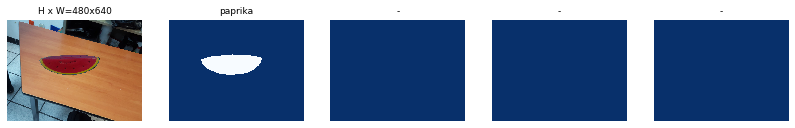

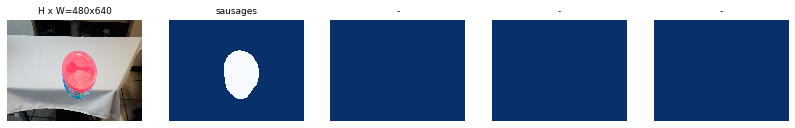

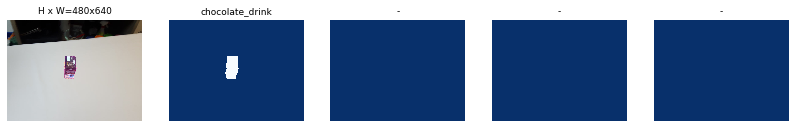

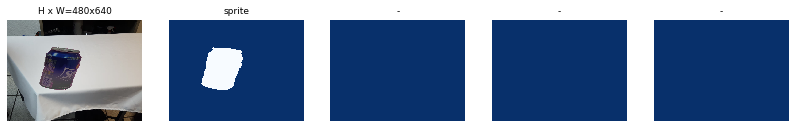

In [69]:

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Creacion del modelo

In [70]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    print(model.find_last()[1])
    model.load_weights(model.find_last()[1], by_name=True)

/home/diego/Documents/mmds/Mobile_Mask_RCNN/logs/1024_objects20191206T1326/mask_rcnn_1024_objects_0204.h5


In [ ]:
import logging
logging.getLogger("PIL").setLevel(logging.INFO)
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            #epochs=4, 
            epochs=100,
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
#print(f'Training took {minutes} minutes')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.


import logging
logging.getLogger("PIL").setLevel(logging.INFO) #Para que no imprima warnings de mi verison de PIL 

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            #epochs=8, 
            epochs=250,
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

# Inferencia

In [71]:
class InferenceConfig(CustomCocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.7
    BACKBONE = "resnet50"
    ## Size Options
    BACKBONE_STRIDES = [4, 8, 16, 32, 64] 
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) 
    MINI_MASK_SHAPE = (56, 56) 


    

inference_config = InferenceConfig()

# Creando un modelo en modo inferencia

In [72]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [73]:

model_path = "../mask_rcnn_objects_0204.h5"

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  ../mask_rcnn_objects_0204.h5


Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_115002.mp4-image-044.jpeg


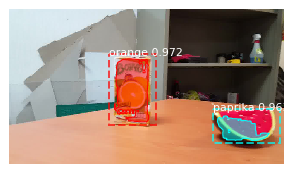

Processing 1 images
image                    shape: (1992, 1120, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1992.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/77306082_791689744588415_5668751515209170944_n.jpg


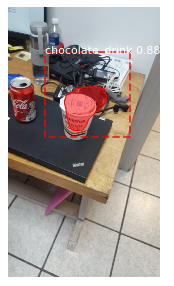

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_120211.mp4-image-048.jpeg


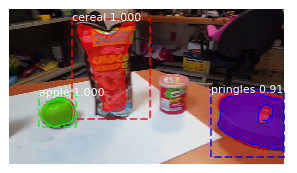

Processing 1 images
image                    shape: (1121, 1992, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1992.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/78414690_508077483132684_5619479388396453888_n.jpg


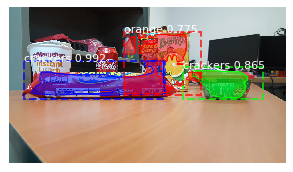

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_115002.mp4-image-037.jpeg


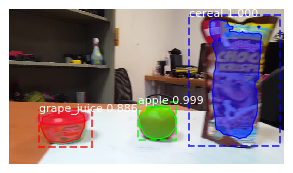

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_120211.mp4-image-045.jpeg


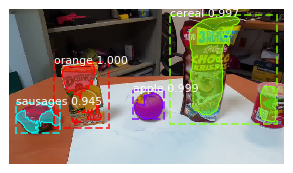

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_120211.mp4-image-009.jpeg


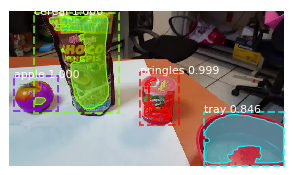

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_120211.mp4-image-021.jpeg


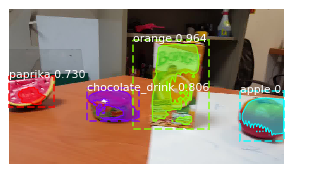

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_120211.mp4-image-043.jpeg


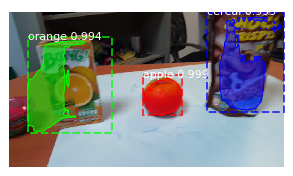

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_115002.mp4-image-032.jpeg


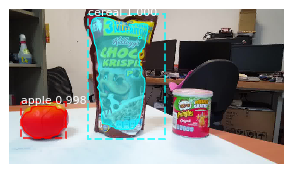

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_120211.mp4-image-006.jpeg


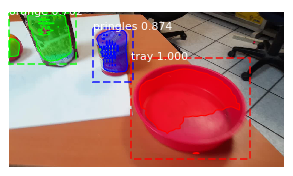

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
../datasets/objects/20191209_115002.mp4-image-040.jpeg


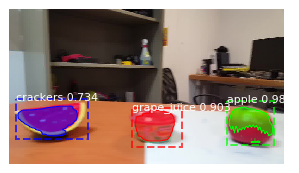

In [74]:
import skimage

real_test_dir = '../datasets/objects/'

image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp']:
        image_paths.append(os.path.join(real_test_dir, filename))

np.random.shuffle(image_paths)
#image_paths.sort()
        
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    print(image_path)
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))